# Train a Mask R-CNN with dropout layers added to its architecture

### Initialize a few paths

In [1]:
weightsfolder = "./weights/broccoli"
resultsfolder = "./results/broccoli"
dataroot = "./datasets/mrcnn"

### Import the most common libraries

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
import warnings
warnings.filterwarnings("ignore")

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.modeling import build_model

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
       
# run on gpu 0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Register the datasets 

In [3]:
register_coco_instances("broccoli_train", {}, os.path.join(dataroot, "train", "annotations.json"), os.path.join(dataroot, "train"))
register_coco_instances("broccoli_val", {}, os.path.join(dataroot, "val", "annotations.json"), os.path.join(dataroot, "val"))
register_coco_instances("broccoli_test", {}, os.path.join(dataroot, "test", "annotations.json"), os.path.join(dataroot, "test"))

broccoli_train_metadata = MetadataCatalog.get("broccoli_train")
broccoli_val_metadata = MetadataCatalog.get("broccoli_val")
broccoli_test_metadata = MetadataCatalog.get("broccoli_test")

dataset_dicts_train = DatasetCatalog.get("broccoli_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_test")

[03/26 10:32:38 d2.data.datasets.coco]: Loaded 2833 images in COCO format from /mnt/nvme2n1p2/PieterBlok/Broccoli oogstrobot/Images/Training_20200804/mrcnn/train/annotations.json
[03/26 10:32:38 d2.data.datasets.coco]: Loaded 606 images in COCO format from /mnt/nvme2n1p2/PieterBlok/Broccoli oogstrobot/Images/Training_20200804/mrcnn/val/annotations.json
[03/26 10:32:38 d2.data.datasets.coco]: Loaded 607 images in COCO format from /mnt/nvme2n1p2/PieterBlok/Broccoli oogstrobot/Images/Training_20200804/mrcnn/test/annotations.json


### Visualize the mask annotations

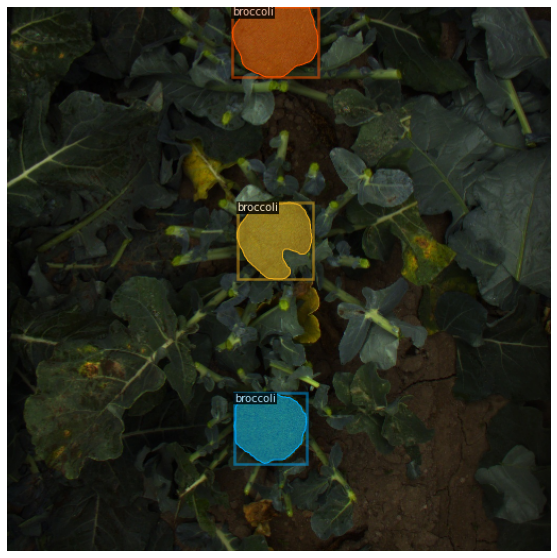

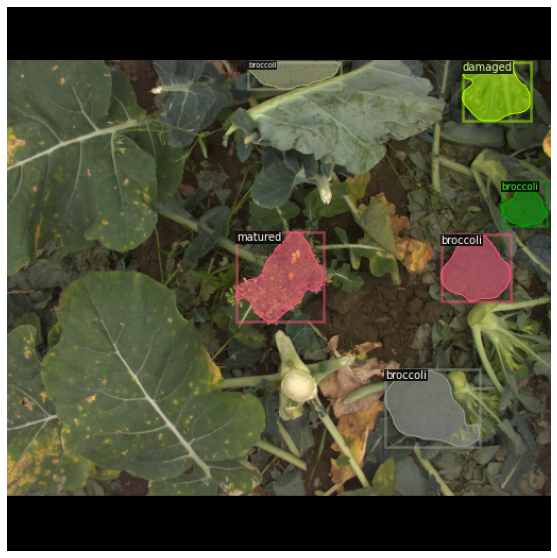

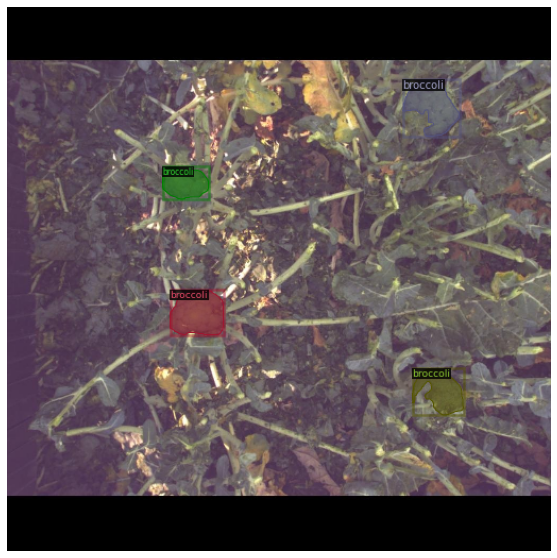

In [4]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    imshow(vis.get_image()[:, :, ::-1])

### Add dropout layers to the architecture of Mask R-CNN

In [5]:
from active_learning.strategies.dropout import FastRCNNConvFCHeadDropout
from active_learning.strategies.dropout import FastRCNNOutputLayersDropout

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_BOX_HEAD.NAME = 'FastRCNNConvFCHeadDropout'
cfg.MODEL.ROI_HEADS.NAME = 'StandardROIHeadsDropout' #StandardROIHeadsDropout is the registry for active_learning.strategies.dropout.FastRCNNOutputLayersDropout
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SOFTMAXES = False

### Initialize the training parameters

In [6]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    
cfg.DATASETS.TRAIN = ("broccoli_train",)
cfg.DATASETS.TEST = ("broccoli_val",)
cfg.NUM_GPUS = 1
cfg.DATALOADER.NUM_WORKERS = 2

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 15000
cfg.SOLVER.STEPS = (1000, 7000, 11000)
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.TEST.EVAL_PERIOD = 500

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 #broccoli, damaged, matured, cateye, headrot

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = weightsfolder
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg) 

[03/26 10:32:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/26 10:32:43 d2.data.datasets.coco]: Loaded 2833 images in COCO format from /mnt/nvme2n1p2/PieterBlok/Broccoli oogstrobot/Images/Training_20200804/mrcnn/train/annotations.json
[03/26 10:32:43 d2.data.build]: Removed 0 images with no usable annotations. 2833 images left.
[03/26 10:32:43 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  broccoli  | 3591         |  damaged   | 422          |  matured   | 346          |
|   cateye   | 551          |  headrot   | 541          |            |              |
|   total    | 5451         |            |              |            |              |
[03/26 10:32:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[0

## Start the training 

In [7]:
trainer.resume_or_load(resume=False)
trainer.train()

## Visualize the training process in tensorboard

In [8]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "./weights/broccoli"

## Evaluation

In [9]:
trainer.resume_or_load(resume=True)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_test",)
predictor = DefaultPredictor(cfg)

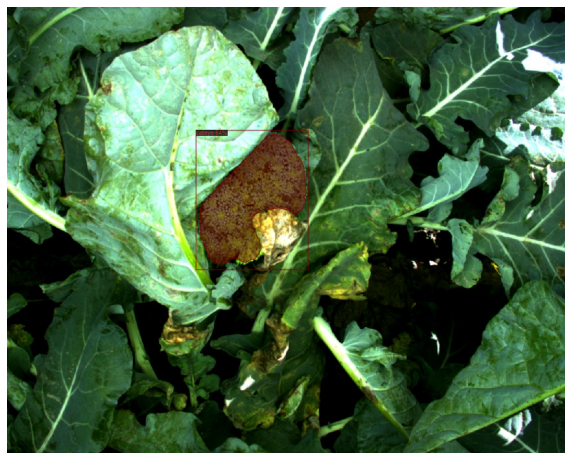

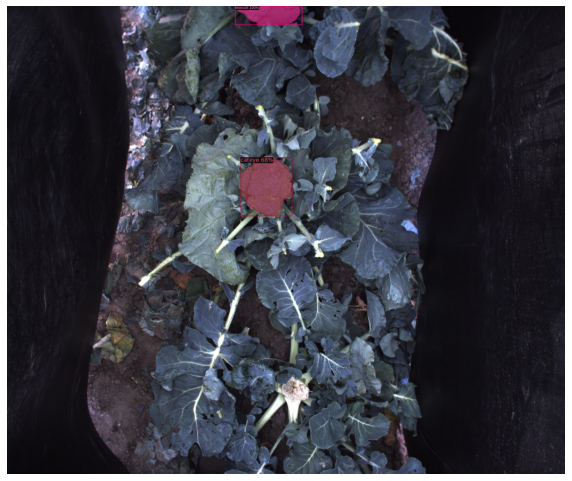

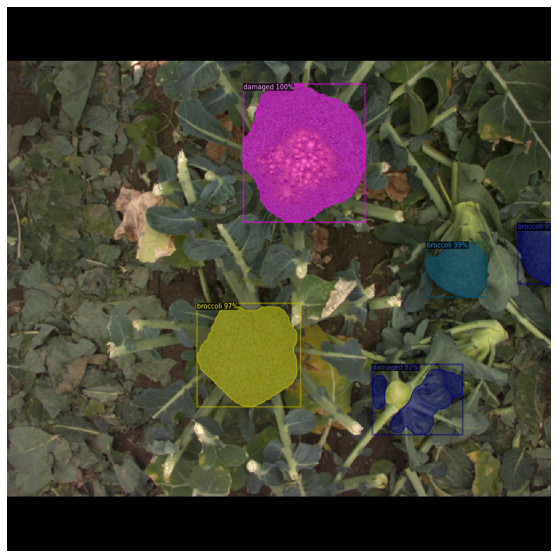

In [10]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

In [11]:
evaluator = COCOEvaluator("broccoli_test", ("bbox", "segm"), False, output_dir=resultsfolder)
val_loader = build_detection_test_loader(cfg, "broccoli_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/26 10:32:49 d2.data.datasets.coco]: Loaded 607 images in COCO format from /mnt/nvme2n1p2/PieterBlok/Broccoli oogstrobot/Images/Training_20200804/mrcnn/test/annotations.json
[03/26 10:32:49 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  broccoli  | 799          |  damaged   | 79           |  matured   | 73           |
|   cateye   | 118          |  headrot   | 132          |            |              |
|   total    | 1201         |            |              |            |              |
[03/26 10:32:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/26 10:32:49 d2.data.common]: Serializing 607 elements to byte tensors and concatenating them all ...
[03/26 10:32:49 d2.data.com

OrderedDict([('bbox',
              {'AP': 10.505998379326105,
               'AP50': 16.007763078503356,
               'AP75': 12.504354562612793,
               'APs': nan,
               'APm': 7.714331217393456,
               'APl': 11.410035920740038,
               'AP-broccoli': 51.27091598903978,
               'AP-damaged': 0.43729372937293737,
               'AP-matured': 0.6237623762376238,
               'AP-cateye': 0.0,
               'AP-headrot': 0.19801980198019803}),
             ('segm',
              {'AP': 11.625739847170413,
               'AP50': 16.19783470227074,
               'AP75': 12.957369994382912,
               'APs': nan,
               'APm': 6.4378056201571585,
               'APl': 13.786481756791819,
               'AP-broccoli': 55.20625699162765,
               'AP-damaged': 1.0066006600660065,
               'AP-matured': 1.1237623762376237,
               'AP-cateye': 0.0,
               'AP-headrot': 0.7920792079207921})])